In [1]:
from google.colab import files
uploaded = files.upload()

Saving Customer_Churn.xlsx to Customer_Churn.xlsx


Baseline accuracy: 50.74%


<ipython-input-3-8c9b0e2d4406>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


DT best params: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 10}
KNN best params: {'n_neighbors': 9, 'weights': 'uniform'}

Decision Tree → Acc: 69.67%, AUC: 0.764
              precision    recall  f1-score   support

        STAY       0.76      0.59      0.67      3044
       LEAVE       0.66      0.80      0.72      2956

    accuracy                           0.70      6000
   macro avg       0.71      0.70      0.69      6000
weighted avg       0.71      0.70      0.69      6000


KNN → Acc: 59.35%, AUC: 0.628
              precision    recall  f1-score   support

        STAY       0.61      0.56      0.58      3044
       LEAVE       0.58      0.63      0.60      2956

    accuracy                           0.59      6000
   macro avg       0.59      0.59      0.59      6000
weighted avg       0.59      0.59      0.59      6000



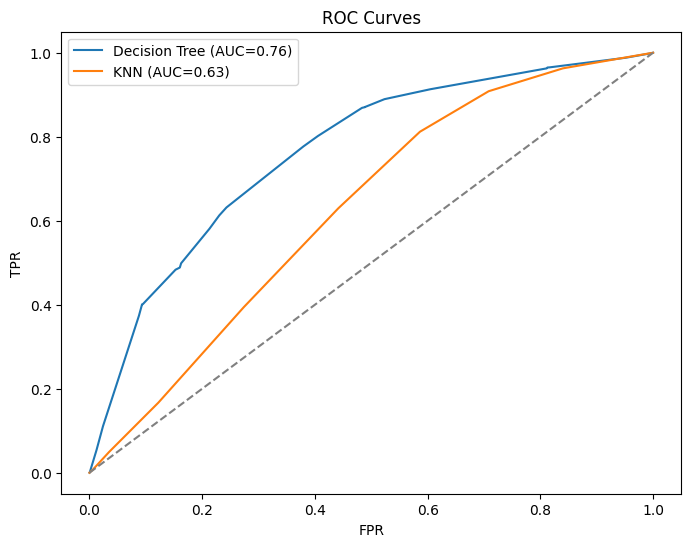

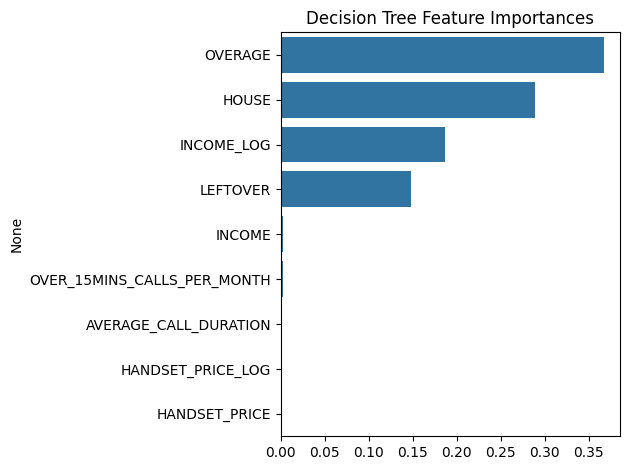


Class distribution:
LEAVE_FLAG
0    0.5074
1    0.4926
Name: proportion, dtype: float64

Top feature‑churn correlations:
OVERAGE                        0.235139
HOUSE                          0.211213
OVER_15MINS_CALLS_PER_MONTH    0.202193
INCOME                         0.096320
HANDSET_PRICE                  0.089221
HANDSET_PRICE_LOG              0.085110
INCOME_LOG                     0.084916
LEFTOVER                       0.060540
AVERAGE_CALL_DURATION          0.008704
Name: LEAVE_FLAG, dtype: float64


In [3]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report



# Load/Clean the data
df = pd.read_excel("Customer_Churn.xlsx")
df.dropna(subset=["OVERAGE","LEFTOVER","HOUSE","HANDSET_PRICE"], inplace=True)
for col in df.select_dtypes(include=["float64","int64"]):
    df[col].fillna(df[col].median(), inplace=True)
df["LEAVE_FLAG"] = df["LEAVE"].map({"STAY":0,"LEAVE":1})
cats = ["COLLEGE","REPORTED_SATISFACTION","REPORTED_USAGE_LEVEL","CONSIDERING_CHANGE_OF_PLAN"]
df = pd.get_dummies(df, columns=[c for c in cats if c in df], drop_first=True)
for col in ["INCOME","HANDSET_PRICE"]:
    if col in df: df[f"{col}_LOG"]=np.log1p(df[col])



# Prepare features & split
X = df.select_dtypes(include=["float64","int64"]).drop("LEAVE_FLAG",axis=1)
y = df["LEAVE_FLAG"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
    )



# Baseline accuracy
baseline = max(y_train.mean(),1-y_train.mean())
print(f"Baseline accuracy: {baseline:.2%}")



# Create/format the Decision Tree
cv = StratifiedKFold(5, shuffle=True, random_state=42)
dt_params = {"max_depth":[3,5,7,None],"min_samples_split":[2,5,10],"class_weight":[None,"balanced"]}
dt_gs = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=cv, scoring="roc_auc", n_jobs=-1)
dt_gs.fit(X_train,y_train)
dt = dt_gs.best_estimator_
print("DT best params:", dt_gs.best_params_)



# Create/Format the KNN
knn_params = {"n_neighbors":[3,5,7,9],"weights":["uniform","distance"]}
knn_gs = GridSearchCV(KNeighborsClassifier(), knn_params, cv=cv, scoring="roc_auc", n_jobs=-1)
knn_gs.fit(X_train,y_train)
knn = knn_gs.best_estimator_
print("KNN best params:", knn_gs.best_params_)



# Evaluate DT and KNN plot ROC curves
plt.figure(figsize=(8,6))
for name, model in [("Decision Tree",dt),("KNN",knn)]:
    p = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test,p)
    auc = roc_auc_score(y_test,proba)
    print(f"\n{name} → Acc: {acc:.2%}, AUC: {auc:.3f}")
    print(classification_report(y_test,p,target_names=["STAY","LEAVE"]))
    fpr,tpr,_ = roc_curve(y_test,proba)
    plt.plot(fpr,tpr,label=f"{name} (AUC={auc:.2f})")
plt.plot([0,1],[0,1],"--",color="gray")
plt.title("ROC Curves"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()



# Show DT feature importances
imp = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=imp.values, y=imp.index)
plt.title("Decision Tree Feature Importances"); plt.tight_layout(); plt.show()



# Show class balance correlations
print("\nClass distribution:")
print(y.value_counts(normalize=True).rename("proportion"))
corrs = X.join(y).corr()["LEAVE_FLAG"].drop("LEAVE_FLAG").abs().sort_values(ascending=False)
print("\nTop feature‑churn correlations:")
print(corrs.head(10))